In [1]:
# Подключаем все необходимые библиотеки.
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.misc as scm  # Для logsumexp и imread.
%matplotlib inline

import math
import tqdm  # Для отображения прогресса.

In [2]:
def read_test(size=3000):
    # 3000 - потому что не хочу запоминать, сколько всего картинок на самом деле.
    test = np.array([]).reshape(0, 3072)  # Размер картинки 32x32, всего 3 цвета, итого 3072.
    for i in tqdm.tqdm(np.arange(size)):
        # Нужен try для случая, если картинки не существует.
        try:
            img = scm.imread('test/test/img_{}.jpg'.format(i)).reshape(1, -1)
            test = np.append(test, img, axis=0)
        except:
            # Ничего не надо делать, переходим к следующей картинке.
            continue
    return test / 127.5 - 1  # Отображаем все числа в отрезок [0; 1].

In [3]:
def read_train(size=7000):
    # 7000 - потому что не хочу запоминать, сколько всего картинок на самом деле.
    sample = np.array([]).reshape(0, 3072)  # Размер картинки 32x32, всего 3 цвета, итого 3072.
    result = np.array([]).reshape(0, 2)  # Векторы вида [0, 1] (indoor) либо [1, 0] (outdoor).
    for i in tqdm.tqdm(np.arange(size)):
        # Переберим теперь тип картинки.
        for res, door in enumerate(['outdoor', 'indoor']):
            # Нужен try для случая, если картинки не существует.
            try:
                img = scm.imread('train/train/{}_{}.jpg'.format(door, i)).reshape(1, -1)
                sample = np.append(sample, img, axis=0)
                # Заполняем вектор ответа - зависит лишь от типа картинки.
                result = np.append(result, np.zeros((1, 2)), axis=0)
                result[-1, res] = 1
            except:
                # Ничего не надо делать, переходим к следующей картинке.
                continue
    return sample / 127.5 - 1, result  # Отображаем всечисла из выборки в отрезок [0; 1].

In [4]:
# Считываем данные, которые будем исследовать.
test = read_test()

100%|██████████████████████████████████████| 3000/3000 [01:34<00:00, 31.60it/s]


In [5]:
# Считываем данные, на которых будем обучаться.
sample, result = read_train()

100%|██████████████████████████████████████| 7000/7000 [06:54<00:00, 16.87it/s]


In [6]:
# Просто посмотрим на их размер.
print(test.shape, sample.shape, result.shape)

(2960, 3072) (6905, 3072) (6905, 2)


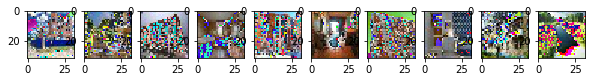

In [7]:
# Пример картинок из выборки. Вывод странненький, но это не наша проблема. =)
plt.figure(figsize=(10, 10))
for i in np.arange(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(np.reshape(sample[i], (32, 32, 3)))


Будем совсем неразумно обучаться на всем train'е, так как тогда мы переобучимся,
то есть наш алгоритм "подгониться" под закономерности, присущие только train'у,
а на реальных данных будет неистово лажать. Так что train разделим на две части:
на 75% будем обучаться, а на 25% проверять, что мы лажаем не неистово.

Если возьмем первые 25% от всего train'а, то может быть несбалансированное число
outdoor'ов и indoor'ов. Поэтому для train возьмем первые 75% outdoor'ов плюс
первые 75% indoor'ов. Тогда мы сохраним пропорции outdoor:indoor таким, какое оно
во всем train'е. Будет особенно клево, если и в исследуемых данных соблюдается так же
пропорция.


In [8]:
# Выделяем outdoor'ы и indoor'ы.
sample_out = sample[result[:, 0] == 1]
sample_in = sample[result[:, 1] == 1]
result_out = result[result[:, 0] == 1]
result_in = result[result[:, 1] == 1]

In [9]:
# Считаем размер indoor- и outdoor-частей в train'е.
train_size_in = int(sample_in.shape[0] * 0.75)
train_size_out = int(sample_out.shape[0] * 0.75)

In [10]:
# Разделяем  outdoor'ы и indoor'ы на обучающую и тестовую часть.
x_train_out, x_test_out = np.split(sample_out, [train_size_out])
y_train_out, y_test_out = np.split(result_out, [train_size_out])
x_train_in, x_test_in = np.split(sample_in, [train_size_in])
y_train_in, y_test_in = np.split(result_in, [train_size_in])

In [11]:
# Делаем общий train и test, смешивая indoor'ы и outdoor'ы.
x_train = np.vstack([x_train_in, x_train_out])
y_train = np.vstack([y_train_in, y_train_out])
x_test = np.vstack([x_test_in, x_test_out])
y_test = np.vstack([y_test_in, y_test_out])

Для каждой картинки мы хотим найти вектор $(p_0, p_1)$, вероятностей такой, что $p_i$ - вероятность того, что картинка принадлежит классу $i$ ($0$ — outdoor, $1$ — indoor).

Реализуя логистическую регрессию, мы хотим приближать вероятности к их настоящему распределению. 

Выражение выдает ответ вида  $$ W x + b, $$


где $x$ — наш вектор картинки, а результат — числовой вектор размерности $2$ с какими-то числами. Для того, чтобы эти числа стали вероятностями от $0$ до $1$, реализуем функцию 
$$
\text{softmax}(W, b, x) = \frac{e^{Wx+b}}{\sum(e^{Wx+b})},
$$
и полученные значения будут как раз давать в сумме 1, и ими мы будем приближать вероятности. 

Оценивать качество нашей модели будем с помощью кросс-энтропии, см. https://en.wikipedia.org/wiki/Cross_entropy.

Сначала поймем, что $x$ - вектор размерности 3072, $W$ - матрица 2 на 3072, $b$ - вектор размерности 2.

Положим $x'_i = x_i$ для $ i \leqslant 3072 $ и $x'_{3073} = 1$. Получили вектор $x'$ размерности 3073. Положим $W'_{i,j} = W_{i,j}$ для $ i \leqslant 2, j \leqslant 3073$ и $W'_{i,3073}=b_i$ для $ i \leqslant 2 $.

Таким образом, к вектору $x$ просто дописали 1, а к матрице $W$ просто приписали вектор $b$ справа.

Заметим теперь, что в точности верно равенство: $Wx+b=W'x'$. Теперь забьем на вектор $b$ и будем считать, что у нас есть матрица 10 на 3073, элементы которой надо оценить. Далее везде считаем $W' = W$ и $x' = x$.

Градиентный спуск считается по формуле: $W_{k+1} = W_k - \eta_k \nabla L(W_k)$, где $\eta_k$ — шаг, а $L$ — функция $\text{loss}$. Значит, нам надо посчитать градиент функции $L$, то есь найти ее частные производные по всем 6146 переменным.

Вспомним, как определяется $L$. Обозначим через $y$ вектор вида $(1, 0)$ либо $(0, 1)$, где 1 на $k$-м месте, где $k - 1$ — тип исследуемой картинки. Размерность $y$ равна 2. Сам вектор $y$ олицетворяет ответ для данной картинки.

Тогда
$$ L(W) = -y_1 \ln \frac{e^{(Wx)_1}}{e^{(Wx)_1} + e^{(Wx)_2}} -y_{2} \ln \frac{e^{(Wx)_{2}}}{e^{(Wx)_1} + e^{(Wx)_2}} + \frac{\lambda}{2} \sum_{i=1}^{2} \sum_{j=1}^{3073} W_{i,j}^2. $$

Последняя сумма — так называемый регуляризатор. Если у нас много признаков (у нас их 6146), то при логистической регресии может возникнуть переобучение. Добавляя все параметры в $\text{loss}$, мы не сможем получить неестественного результата, когда какие-то параметры очень маленькие, а какие-то очень большие, потому что большие будут сильно увеличивать регуляризатор, а функция минимизируется. Таким образом, более вероятно получение подходящего результата.

Это описано в курсе Machine Learning by Stanford University во втором уроке третьей недели. Ссылка: https://www.coursera.org/learn/machine-learning/lecture/4BHEy/regularized-logistic-regression.

Теперь найдем производную по $W_{i,j}$: $$
\frac{dL(W)}{dW_{i,j}} =
-y_1 \frac{e^{(Wx)_1} + e^{(Wx)_2}}{e^{(Wx)_1}} \cdot
\frac{-e^{(Wx)_1} e^{(Wx)_i} x_j}
{e^{(Wx)_1} + e^{(Wx)_2}}
-y_{2} \frac{e^{(Wx)_1} + e^{(Wx)_2}}{e^{(Wx)_{2}}} \cdot
\frac{-e^{(Wx)_{2}} e^{(Wx)_i} x_j}
{e^{(Wx)_1} + e^{(Wx)_2}} -\\
- y_i \frac{e^{(Wx)_1} + e^{(Wx)_2}}{e^{(Wx)_i}} \cdot
\frac{e^{(Wx)_i} x_j (e^{(Wx)_1} + e^{(Wx)_2})}
{(e^{(Wx)_1} + e^{(Wx)_2})^2}
+ \lambda W_{i,j}. $$

Упростим немного: $$
\frac{dL(W)}{dW_{i,j}} =
\frac{ x_j e^{(Wx)_i} (y_1 + y_2) }
{e^{(Wx)_1} + e^{(Wx)_2}}
-y_i x_j
+ \lambda W_{i,j}. $$

Упрощая еще сильнее, приходим к окончательному ответу:  $$
\frac{dL(W)}{dW_{i,j}} =\left( \frac{e^{(Wx)_i}}{e^{(Wx)_1} + e^{(Wx)_2}} - y_i \right) x_j
+ \lambda W_{i,j}.
$$
Соответственно, если $j = 3073$, то есть дифференцируем по переменным $ W_{1, 3073} = b_1, \ldots, W_{2, 3073} = b_2$, то коэффициент перед скобкой просто 1.

Перейдем к реализации.

In [12]:
def softmax(W, x):
    # Функция logsumexp более стабтильно вычисляет функцию экспонент, почти
    # избавляя нас от проблемы переполнения.
    p = np.dot(x, W.T)
    return np.exp(p - scm.logsumexp(p, axis=1).reshape(-1, 1))

In [13]:
def loss(y, softmax, W, l):
    # Формула из Википедии по ссылке выше c добавленным регуляризатором.
    return np.mean(-np.sum(y * np.log(softmax), axis=1)) + l * np.trace(W @ W.T) / (2 * y.shape[0])

In [14]:
# Считаем средний по всем картинкам градиент.
# Градиент у нас будет не вектор, как мы привыкли, а матрица 2x3073.
def gradients(W, x, y, l):
    p = softmax(W, x)
    grads = (p - y).T @ x + l * W
    return grads / x.shape[0]  # По максимимум матричных вычислений!

In [15]:
# Выбор шага по правилу Армихо из семинарского листочка.
def armijo(W, x, y, l, alpha=0.5, beta=0.5):
    s = 1
    grad = gradients(W, x, y, l)
    dW = -grad  # Направление спуска.
    loss_1 = loss(y_train, softmax(W + s * dW, x), W, l)
    loss_0 = loss(y_train, softmax(W, x), W, l)
    while loss_1 > loss_0 + alpha * s * (grad * dW).sum():
        s = beta * s
        loss_1 = loss(y_train, softmax(W + s * dW, x), W, l)
        loss_0 = loss(y_train, softmax(W, x), W, l)
    return s

In [16]:
def classify(x_train, x_test, y_train, y_test, iters, l):
    # Как было замечено выше, W Размера 2 на 3072, а b размера 2, но мы приписываем b к W.
    W = np.zeros((2, 3072))
    b = np.zeros(2)

    # Для приписывания запишем b как вектор столбец и воспользуемся функцией hstack.
    b = b.reshape(b.size, 1)
    W = np.hstack([W, b])

    # Соответственно, нужно поменять x_train и x_test, добавив по 1 снизу.
    fictious = np.ones((x_train.shape[0], 1))
    x_train = np.hstack([x_train, fictious])
    fictious = np.ones((x_test.shape[0], 1))
    x_test = np.hstack([x_test, fictious])

    # Будем записывать потери на каждом шаге спуска.
    losses_train = [loss(y_train, softmax(W, x_train), W, l)]
    losses_test = [loss(y_test, softmax(W, x_test), W, l)]

    # Собственно, сам спуск.
    for i in tqdm.tqdm(np.arange(iters)):
        # Именно так - в Армихо подставляется alpha = l, а l = 0!
        # Потому что я накосячил и не заметил! =)
        eta = armijo(W, x_train, y_train, 0, l)
        W = W - eta * gradients(W, x_train, y_train, l)
        losses_train.append(loss(y_train, softmax(W, x_train), W, l))
        losses_test.append(loss(y_test, softmax(W, x_test), W, l))

    # На выходе имеется оптимальное значение W и массивы потерь.
    return W, losses_train, losses_test

In [17]:
l = 0.04  # Сработает лучше, чем вообще без регуляризатора (l = 0).

In [18]:
# Нам хватит и 100 итераций, переобучение начинается достаточно быстро.
W, losses_train, losses_test = classify(x_train, x_test, y_train, y_test, 100, l)

100%|████████████████████████████████████████| 100/100 [00:29<00:00,  3.34it/s]


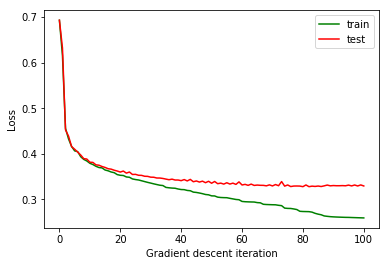

In [19]:
plt.plot(losses_train, color='green', label='train')
plt.plot(losses_test, color='red', label='test')
plt.xlabel('Gradient descent iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
iters = np.argmin(losses_test)  # На этой итиреации ошибка на тесте минимальна.

In [21]:
# Делаем столько итераций.
W, losses_train, losses_test = classify(x_train, x_test, y_train, y_test, iters, l)

100%|██████████████████████████████████████████| 82/82 [00:26<00:00,  3.12it/s]


Посчитаем среднюю квадратичную ошибку на тесте, чтобы прикинуть, что будет на Kaggle.

In [22]:
# Добавляем 1 к выборке.
nx_test = np.hstack([x_test, np.ones(x_test.shape[0]).reshape(x_test.shape[0], 1)])
probabilities = softmax(W, nx_test)  # Считаем вероятности.
recognized = np.argmax(probabilities, axis=1)  # Что распознано.
answers = np.argmax(y_test, axis=1)  # Правильные ответы.

In [23]:
np.sqrt(np.mean((recognized - answers) ** 2))  # Собственно, ошибка.

0.35447343856070407

Теперь применяем найденную матрицу к исследумемым данным.

In [24]:
# Добавляем 1 к выборке.
ntest = np.hstack([test, np.ones(test.shape[0]).reshape(test.shape[0], 1)])
probabilities = softmax(W, ntest)  # Считаем вероятности.
ress = np.argmax(probabilities, axis=1).reshape(-1, 1)  # Что распознано.

In [25]:
# Осталось загнать все в табличку, чтобы ее записать в csv.
ids = np.arange(ress.size).reshape(-1, 1)
submit = np.hstack([ids, ress])

In [26]:
# Заполняем csv-шник.
import csv
with open('submission.csv', 'w', newline='') as csvfile:
    submission = csv.writer(csvfile, delimiter=',')
    submission.writerow(['id', 'res'])
    submission.writerows(submit)

Вот и готово.